# Plotting Source Sink Cross Validation Experiment

Acknowledgements: See https://github.com/sipv/MultipanelFigures/blob/main/MultipanelFigures.ipynb for a great explanation on laying out figures in matplotlib

In [1]:
%load_ext lab_black

In [2]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle

from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals
import pingouin as pg

from sklearn.metrics import auc

from mlxtend.evaluate import mcnemar_table, mcnemar

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import dabest

/Users/adam2392/miniforge3/envs/eztrack/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Set Plotting Options

In [3]:
# Set font sizes

SMALL_SIZE = 8 * 2
MEDIUM_SIZE = 10 * 2
BIGGER_SIZE = 12 * 2

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc("font", **{"family": "sans-serif", "sans-serif": ["Arial"]})

# Load Data

In [4]:
root = Path("/Users/adam2392/OneDrive - Johns Hopkins/epilepsy_interictal")
# root = Path("/home/adam2392/hdd/Dropbox/epilepsy_interictal")
deriv_root = root / "derivatives"
source_root = root / "sourcedata"

session = "presurgery"
task = "interictal"
acquisition = "seeg"  # note not all subjects are actually sEEG
reference = "car"
deriv_chain = Path("sourcesink") / reference / "remove_artifact_wins"

deriv_path = deriv_root / deriv_chain

figure_dir = Path("./figures/")
figure_dir.mkdir(exist_ok=True)

In [5]:
meta_fpath = source_root / "ieeg_database_all.xlsx"

## Obtain Labels Using Excel Sheet

In [6]:
meta_df = pd.read_excel(meta_fpath)

display(meta_df.head(2))

,org_patientid,patient_id,number_datasets,clinical_center,modality,sfreq,previous_surgery?,clinical_complexity,engel_score,ilae_score,...,mri_outcome,postop_progress_info,date_of_recording,date_of_surgery,date_of_last_follow_up,years_follow_up,engel_class_full,notes,Unnamed: 38,Unnamed: 39
0,NaN,la01,1,cc,seeg,1000,"Y (SEEG implant 4/2013, craniotomy 4/2013)",4,4,4.0,...,Normal,Seizure free since surgery.,2013-04-10 02:11:44,2014-01-01 00:00:00,2019-10-01 00:00:00,5,NaN,NaN,NaN,NaN
1,NaN,la02,1,cc,seeg,1000,VNS implant 4/24/2014,1,1,1.0,...,Normal,Seizure free since surgery.,NaN,2015-02-01 00:00:00,2018-11-01 00:00:00,3,NaN,PPT says: Lesion?,NaN,NaN


## Load Source-Sink Data

In [7]:
n_splits = 10

clf_name = "sporf"
n_features = 15
n_estimators = (2000,)
max_features = n_features * 2

# other options:
# source_infl
# sink_ind
# sink_conn
# feature_name = "source_infl"

In [8]:
fname = (
    Path("./data")
    / f"cv{n_splits}_{clf_name}_mtry{max_features}_exp_allfeats_meandiff.json"
)
print(fname)

data/cv10_sporf_mtry30_exp_allfeats_meandiff.json


In [9]:
with open(fname.with_suffix(".json"), "r") as fp:
    ss_scores = json.load(fp)

## Load HFO Data

In [10]:
max_features = 10

In [11]:
fname = (
    Path("./data")
    / f"cv{n_splits}_{clf_name}_mtry{max_features}_exp_hforates_meandiff.pkl"
)
print(fname)

data/cv10_sporf_mtry10_exp_hforates_meandiff.pkl


In [12]:
with open(fname.with_suffix(".json"), "r") as fp:
    hfo_scores = json.load(fp)

## Or Load Hilbert HFO Data

In [13]:
max_features = 10

In [14]:
fname = (
    Path("./data")
    / f"cv{n_splits}_{clf_name}_mtry{max_features}_exp_hilberthforates_meandiff.pkl"
)
print(fname)

data/cv10_sporf_mtry10_exp_hilberthforates_meandiff.pkl


In [15]:
with open(fname.with_suffix(".json"), "r") as fp:
    hfo_scores = json.load(fp)

# Make Plots of the Source Sink Data

In [16]:
scores = ss_scores

In [17]:
# either train or test set
which_set = "test"

# construct mean/std ROC curves
tprs = []
aucs = scores[f"{which_set}_roc_auc"]
mean_fpr = np.linspace(0, 1, 100)

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    # interpolate the tpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

## Print out Summary Statistics

In [18]:
print(np.mean(aucs), np.std(aucs))

0.8575757575757577 0.0678273614715133


In [19]:
print(np.mean(aucs), np.std(aucs))

0.8575757575757577 0.0678273614715133


In [20]:
metric = "test_balanced_accuracy"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_balanced_accuracy 0.7888888888888889 +/- 0.08089641636434715


In [21]:
metric = "test_average_precision"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_average_precision 0.8771193623580105 +/- 0.06047213835142888


In [22]:
metric = "test_recall"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_recall 0.7777777777777777 +/- 0.08606629658238704


In [23]:
metric = "test_specificity"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_specificity 0.8 +/- 0.15102952478032863


In [24]:
metric = "test_f1"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_f1 0.7727506319079882 +/- 0.08179035489128354


In [25]:
# create a dataframe from the statistics
temp_scores = scores.copy()
keys = list(temp_scores.keys())
for key in keys:
    if any(
        [
            chars in key
            for chars in [
                "fpr",
                "tpr",
                "fnr",
                "tnr",
                "threshold",
                "fraction_pos",
                "mean_pred_value",
                "subjects",
                "y_pred_proba",
                "importances",
                "train",
            ]
        ]
    ):
        temp_scores.pop(key)
score_df = pd.DataFrame(temp_scores)

display(score_df.head())

,fit_time,score_time,test_roc_auc,test_accuracy,test_balanced_accuracy,test_average_precision,test_precision,test_neg_brier_score,test_recall,test_f1,test_specificity
0,3.183684,1.027003,0.818182,0.75,0.752525,0.836420,0.700000,-0.174114,0.777778,0.736842,0.727273
1,1.931161,1.220786,0.878788,0.80,0.797980,0.893827,0.777778,-0.157007,0.777778,0.777778,0.818182
2,1.890555,1.058255,0.838384,0.75,0.742424,0.827876,0.750000,-0.180518,0.666667,0.705882,0.818182
3,2.327900,0.873741,0.959596,0.95,0.944444,0.965812,1.000000,-0.114240,0.888889,0.941176,1.000000
4,2.050133,0.968666,0.737374,0.70,0.696970,0.765859,0.666667,-0.221338,0.666667,0.666667,0.727273


In [26]:
ss_score_df = score_df.copy()

In [27]:
score_df.describe().to_csv(f"./data/{clf_name}_sourcesink_metrics_meansstd.csv")

## Making ROC Curve With Confidence Interval

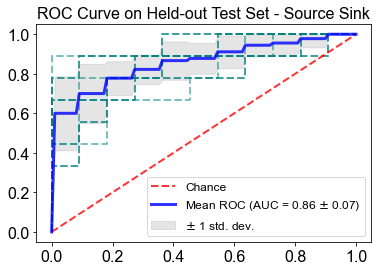

In [28]:
fig, ax = plt.subplots()

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    ax.plot(fpr, tpr, color="teal", lw=2, alpha=0.5, ls="--")

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=3,
    alpha=0.8,
)


ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"ROC Curve on Held-out Test Set - Source Sink",
)
ax.legend(loc="lower right", fontsize=12)
plt.show()

# And save it to PDF
fig.savefig(f"./{figure_dir}/roc_curve_ss.pdf", bbox_inches="tight")

## Plotting Predicted Probability of Success Scores

In [29]:
y_probas = []
subj_list = []
outcomes = []
centers = []
folds = []
engels = []
ilaes = []

for idx in range(n_splits):
    y_pred_proba = scores[f"{which_set}_y_pred_proba"][idx]
    cv_subjects = scores[f"{which_set}_subjects"][idx]
    for subject in cv_subjects:
        outcome = meta_df[meta_df["patient_id"] == subject]["outcome"].values[0]
        outcomes.append(outcome)

        engel = meta_df[meta_df["patient_id"] == subject]["engel_score"].values[0]
        engels.append(engel)

        ilae = meta_df[meta_df["patient_id"] == subject]["ilae_score"].values[0]
        ilaes.append(ilae)

        center = meta_df[meta_df["patient_id"] == subject]["clinical_center"].values[0]
        centers.append(center)

    y_probas.extend(y_pred_proba)
    subj_list.extend(cv_subjects)
    folds.extend([idx] * len(cv_subjects))

In [30]:
proba_df = pd.DataFrame(
    (y_probas, subj_list, outcomes, engels, ilaes, centers, folds)
).T
proba_df.columns = ["y_proba", "subject", "outcome", "engel", "ilae", "center", "fold"]

proba_df["center"] = proba_df["center"].map(
    {
        "jhu": "JHH",
        "miami": "Miami",
        "cc": "CClinic",
        "upmc": "UPMC",
        "kumc": "KUMC",
        "nih": "NIH",
    }
)

display(proba_df.head())

,y_proba,subject,outcome,engel,ilae,center,fold
0,0.609425,PY19N023,S,1,1.0,JHH,0
1,0.335533,la16,F,4,5.0,CClinic,0
2,0.292,rns015,F,2,NaN,Miami,0
3,0.653967,upmc3,F,2,3.0,UPMC,0
4,0.551758,la21,S,1,1.0,CClinic,0


In [31]:
ss_proba_df = proba_df.copy()

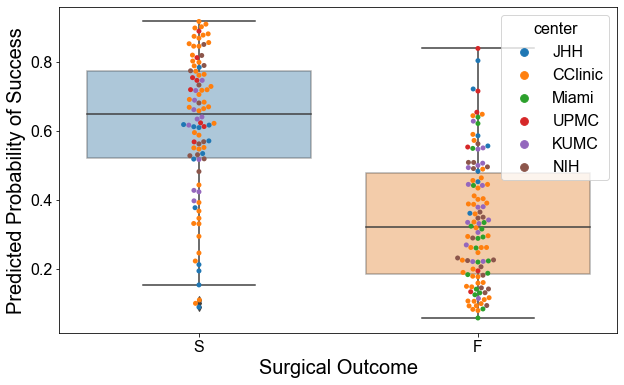

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))
# sns.stripplot(x="outcome", y="y_proba", hue="center", data=proba_df, ax=ax)
sns.boxplot(x="outcome", y="y_proba", data=proba_df, ax=ax, boxprops=dict(alpha=0.4))
sns.swarmplot(x="outcome", y="y_proba", hue="center", data=proba_df, ax=ax)

ax.set(
    ylabel="Predicted Probability of Success",
    xlabel="Surgical Outcome",
)
fig.savefig(
    f"./{figure_dir}/ss_y_pred_proba_surgical_outcomes.pdf", bbox_inches="tight"
)

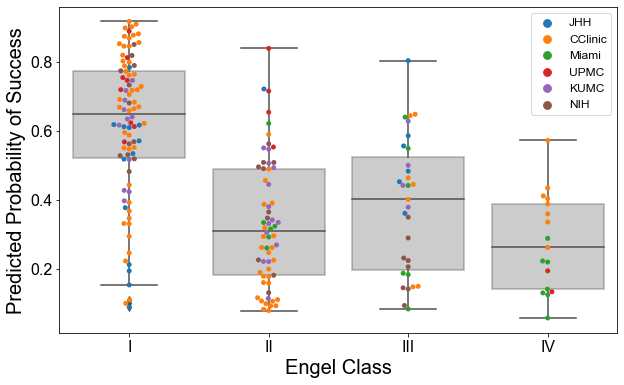

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
# sns.stripplot(x="outcome", y="y_proba", hue="center", data=proba_df, ax=ax)
sns.boxplot(
    x="engel", y="y_proba", data=proba_df, ax=ax, color="gray", boxprops=dict(alpha=0.4)
)
sns.swarmplot(x="engel", y="y_proba", hue="center", data=proba_df, ax=ax)

ax.set(
    ylabel="Predicted Probability of Success",
    xlabel="Engel Class",
    xticklabels=["I", "II", "III", "IV"],
)
ax.legend(loc="upper right", fontsize=12)
fig.savefig(f"./{figure_dir}/ss_y_pred_proba_engel.pdf", bbox_inches="tight")

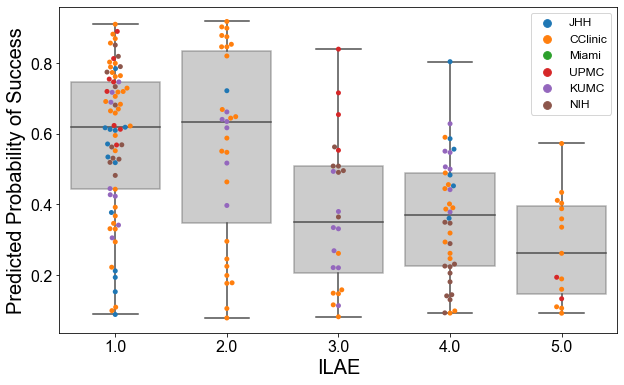

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
# sns.stripplot(x="outcome", y="y_proba", hue="center", data=proba_df, ax=ax)
sns.boxplot(
    x="ilae", y="y_proba", data=proba_df, ax=ax, color="gray", boxprops=dict(alpha=0.4)
)
sns.swarmplot(x="ilae", y="y_proba", hue="center", data=proba_df, ax=ax)

ax.set(
    ylabel="Predicted Probability of Success",
    xlabel="ILAE",
    #     xticklabels=["I", "II", "III", "IV"],
)
ax.legend(loc="upper right", fontsize=12)
fig.savefig(f"./{figure_dir}/ss_y_pred_proba_ilae.pdf", bbox_inches="tight")

## Boundary Split Figure

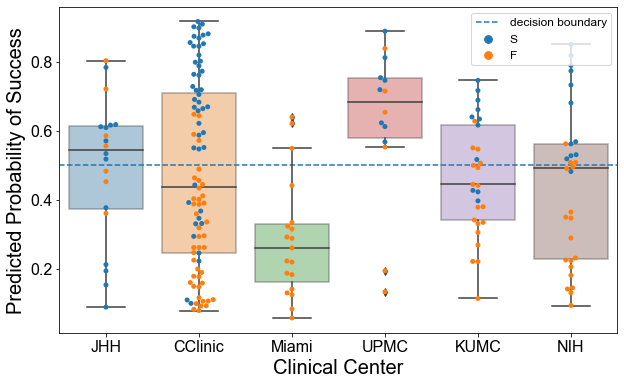

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))
# sns.stripplot(x="outcome", y="y_proba", hue="center", data=proba_df, ax=ax)
ax.axhline([0.5], ls="--", label="decision boundary")
sns.boxplot(x="center", y="y_proba", data=proba_df, ax=ax, boxprops=dict(alpha=0.4))
sns.swarmplot(x="center", y="y_proba", hue="outcome", data=proba_df, ax=ax)
ax.set(
    ylabel="Predicted Probability of Success",
    xlabel="Clinical Center",
)
ax.legend(fontsize=12)
fig.savefig(f"./{figure_dir}/ss_boundary_split_center.pdf", bbox_inches="tight")

## Plotting Calibration Curve

In [36]:
mean_brier = np.mean(scores["test_neg_brier_score"])
std_brier = np.std(scores["test_neg_brier_score"])

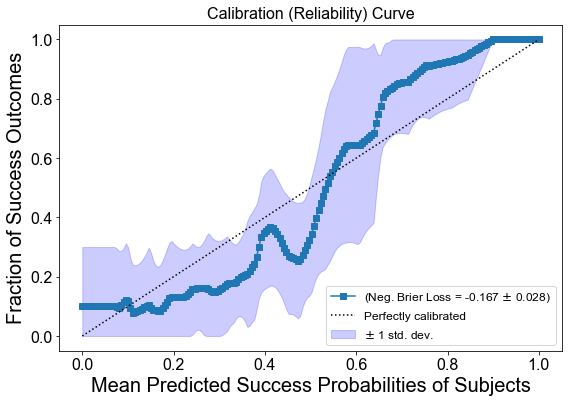

In [37]:
frac_pred_vals = []
mean_pred_values = np.linspace(0, 1.0, 200)

fig, ax = plt.subplots(figsize=(9, 6))
color = "blue"
for idx in range(n_splits):
    y_pred_proba = scores[f"{which_set}_y_pred_proba"][idx]

    mean_predicted_value = scores[f"{which_set}_mean_pred_value"][idx]
    fraction_of_positives = scores[f"{which_set}_fraction_pos"][idx]

    # create a linear interpolation of the calibration
    interp_frac_positives = np.interp(
        mean_pred_values, mean_predicted_value, fraction_of_positives
    )

    # store curves
    frac_pred_vals.append(interp_frac_positives)
#     ax.plot(mean_pred_values, interp_frac_positives, "s-", alpha=0.5)

# get the mean calibration curve
mean_frac_pred_values = np.mean(frac_pred_vals, axis=0)
ax.plot(
    mean_pred_values,
    mean_frac_pred_values,
    "s-",
    label=rf"(Neg. Brier Loss = {np.round(mean_brier,3)} $\pm$ {np.round(std_brier, 3)})",
)

# get upper and lower bound for tpr
std_fpv = np.std(frac_pred_vals, axis=0)
tprs_upper = np.minimum(mean_frac_pred_values + std_fpv, 1)
tprs_lower = np.maximum(mean_frac_pred_values - std_fpv, 0)
ax.fill_between(
    mean_pred_values,
    tprs_lower,
    tprs_upper,
    color=color,
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")


ax.set(
    ylabel="Fraction of Success Outcomes",
    ylim=[-0.05, 1.05],
    xlabel="Mean Predicted Success Probabilities of Subjects",
    title="Calibration (Reliability) Curve",
)

ax.legend(loc="lower right", fontsize=12)
plt.show()

fig.savefig(f"./{figure_dir}/ss_calibration_curve.pdf", bbox_inches="tight")

# Make Plots of the HFO Data

In [38]:
scores = hfo_scores

In [39]:
# either train or test set
which_set = "test"

# construct mean/std ROC curves
tprs = []
aucs = scores[f"{which_set}_roc_auc"]
mean_fpr = np.linspace(0, 1, 100)

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    # interpolate the tpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

## Print out Summary Statistics

In [40]:
print(np.mean(aucs), np.std(aucs))

0.7227272727272727 0.06882228184919997


In [41]:
print(np.mean(aucs), np.std(aucs))

0.7227272727272727 0.06882228184919997


In [42]:
metric = "test_balanced_accuracy"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_balanced_accuracy 0.6661616161616162 +/- 0.09594497496268233


In [43]:
metric = "test_average_precision"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_average_precision 0.7163628488718788 +/- 0.10022623048666207


In [44]:
metric = "test_recall"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_recall 0.5777777777777777 +/- 0.17069212773041353


In [45]:
metric = "test_specificity"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_specificity 0.7545454545454546 +/- 0.12230567315521554


In [46]:
metric = "test_f1"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_f1 0.605309210053792 +/- 0.14101163706154013


In [47]:
# create a dataframe from the statistics
temp_scores = scores.copy()
keys = list(temp_scores.keys())
for key in keys:
    if any(
        [
            chars in key
            for chars in [
                "fpr",
                "tpr",
                "fnr",
                "tnr",
                "threshold",
                "fraction_pos",
                "mean_pred_value",
                "subjects",
                "y_pred_proba",
                "importances",
                "train",
            ]
        ]
    ):
        temp_scores.pop(key)
score_df = pd.DataFrame(temp_scores)

display(score_df.head())

,fit_time,score_time,test_roc_auc,test_accuracy,test_balanced_accuracy,test_average_precision,test_precision,test_neg_brier_score,test_recall,test_f1,test_specificity
0,0.045636,0.007776,0.828283,0.75,0.752525,0.833267,0.700000,-0.170620,0.777778,0.736842,0.727273
1,0.041809,0.004078,0.621212,0.50,0.474747,0.596543,0.400000,-0.273767,0.222222,0.285714,0.727273
2,0.031490,0.005477,0.656566,0.65,0.651515,0.560953,0.600000,-0.263108,0.666667,0.631579,0.636364
3,0.039651,0.005620,0.717172,0.60,0.595960,0.705371,0.555556,-0.223583,0.555556,0.555556,0.636364
4,0.043391,0.004906,0.636364,0.60,0.606061,0.565305,0.545455,-0.239745,0.666667,0.600000,0.545455


In [48]:
hfo_scores_df = score_df.copy()

In [49]:
score_df.describe().to_csv(f"./data/{clf_name}_hilberthfo_metrics_meansstd.csv")

## Making ROC Curve With Confidence Interval

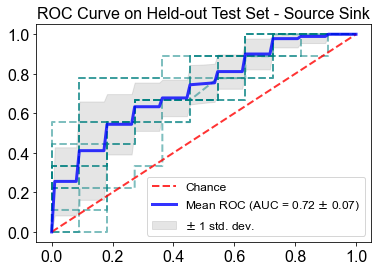

In [50]:
fig, ax = plt.subplots()

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    ax.plot(fpr, tpr, color="teal", lw=2, alpha=0.5, ls="--")

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=3,
    alpha=0.8,
)


ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"ROC Curve on Held-out Test Set - Source Sink",
)
ax.legend(loc="lower right", fontsize=12)
plt.show()

# And save it to PDF
fig.savefig(f"./{figure_dir}/roc_curve_hilberthfo.pdf", bbox_inches="tight")

## Plotting Predicted Probability of Success Scores

In [51]:
y_probas = []
subj_list = []
outcomes = []
centers = []
folds = []
engels = []
ilaes = []

for idx in range(n_splits):
    y_pred_proba = scores[f"{which_set}_y_pred_proba"][idx]
    cv_subjects = scores[f"{which_set}_subjects"][idx]
    for subject in cv_subjects:
        outcome = meta_df[meta_df["patient_id"] == subject]["outcome"].values[0]
        outcomes.append(outcome)

        engel = meta_df[meta_df["patient_id"] == subject]["engel_score"].values[0]
        engels.append(engel)

        ilae = meta_df[meta_df["patient_id"] == subject]["ilae_score"].values[0]
        ilaes.append(ilae)

        center = meta_df[meta_df["patient_id"] == subject]["clinical_center"].values[0]
        centers.append(center)

    y_probas.extend(y_pred_proba)
    subj_list.extend(cv_subjects)
    folds.extend([idx] * len(cv_subjects))

In [52]:
proba_df = pd.DataFrame(
    (y_probas, subj_list, outcomes, engels, ilaes, centers, folds)
).T
proba_df.columns = ["y_proba", "subject", "outcome", "engel", "ilae", "center", "fold"]

proba_df["center"] = proba_df["center"].map(
    {
        "jhu": "JHH",
        "miami": "Miami",
        "cc": "CClinic",
        "upmc": "UPMC",
        "kumc": "KUMC",
        "nih": "NIH",
    }
)

display(proba_df.head())

,y_proba,subject,outcome,engel,ilae,center,fold
0,0.332,PY19N023,S,1,1.0,JHH,0
1,0.1165,la16,F,4,5.0,CClinic,0
2,0.269,rns015,F,2,NaN,Miami,0
3,0.7615,upmc3,F,2,3.0,UPMC,0
4,0.6995,la21,S,1,1.0,CClinic,0


In [53]:
hfo_proba_df = proba_df.copy()

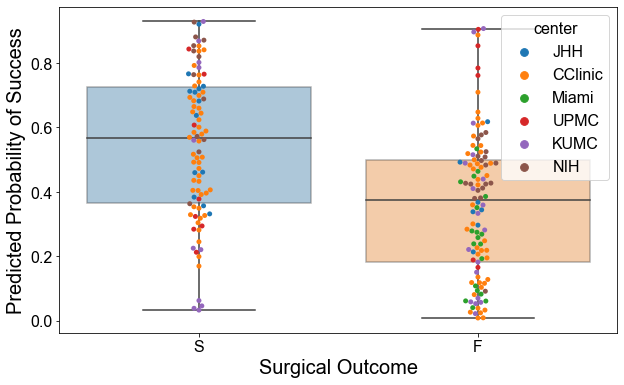

In [54]:
fig, ax = plt.subplots(figsize=(10, 6))
# sns.stripplot(x="outcome", y="y_proba", hue="center", data=proba_df, ax=ax)
sns.boxplot(
    x="outcome",
    y="y_proba",
    data=proba_df,
    ax=ax,
    boxprops=dict(alpha=0.4),
    # palette=["black", "red"],
)
sns.swarmplot(x="outcome", y="y_proba", hue="center", data=proba_df, ax=ax)

ax.set(
    ylabel="Predicted Probability of Success",
    xlabel="Surgical Outcome",
)
fig.savefig(
    f"./{figure_dir}/hilbert_hfo_y_pred_proba_surgical_outcomes.pdf",
    bbox_inches="tight",
)

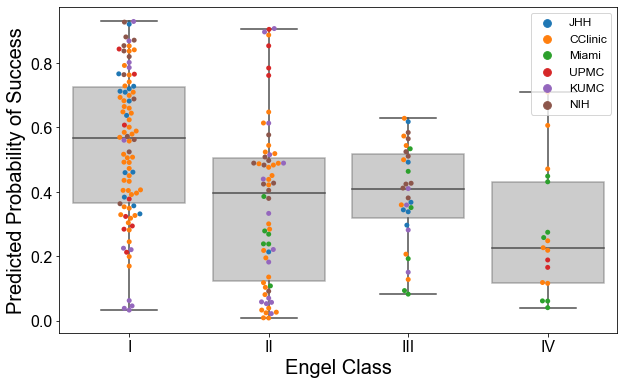

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))
# sns.stripplot(x="outcome", y="y_proba", hue="center", data=proba_df, ax=ax)
sns.boxplot(
    x="engel", y="y_proba", data=proba_df, ax=ax, color="gray", boxprops=dict(alpha=0.4)
)
sns.swarmplot(x="engel", y="y_proba", hue="center", data=proba_df, ax=ax)

ax.set(
    ylabel="Predicted Probability of Success",
    xlabel="Engel Class",
    xticklabels=["I", "II", "III", "IV"],
)
ax.legend(loc="upper right", fontsize=12)
fig.savefig(f"./{figure_dir}/hilbert_hfo_y_pred_proba_engel.pdf", bbox_inches="tight")

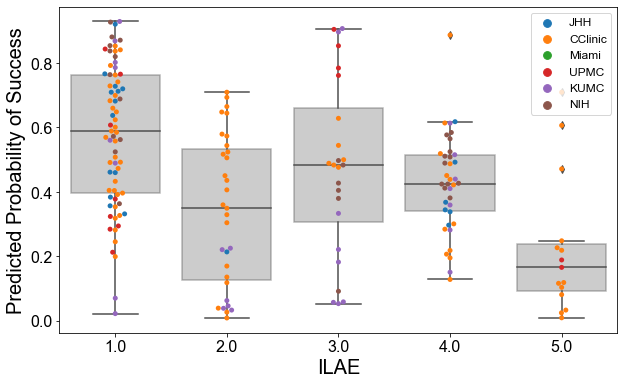

In [56]:
fig, ax = plt.subplots(figsize=(10, 6))
# sns.stripplot(x="outcome", y="y_proba", hue="center", data=proba_df, ax=ax)
sns.boxplot(
    x="ilae", y="y_proba", data=proba_df, ax=ax, color="gray", boxprops=dict(alpha=0.4)
)
sns.swarmplot(x="ilae", y="y_proba", hue="center", data=proba_df, ax=ax)

ax.set(
    ylabel="Predicted Probability of Success",
    xlabel="ILAE",
    #     xticklabels=["I", "II", "III", "IV"],
)
ax.legend(loc="upper right", fontsize=12)
fig.savefig(f"./{figure_dir}/hilbert_hfo_y_pred_proba_ilae.pdf", bbox_inches="tight")

## Boundary Split Figure

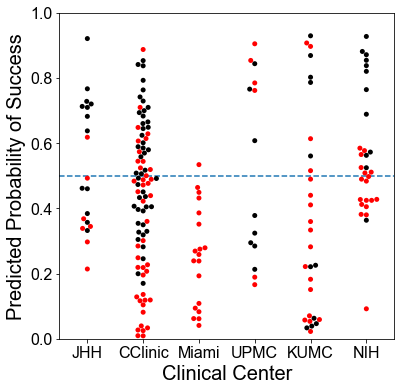

In [57]:
fig, ax = plt.subplots(figsize=(6, 6))
# sns.stripplot(x="outcome", y="y_proba", hue="center", data=proba_df, ax=ax)
ax.axhline([0.5], ls="--", label="decision boundary")
# sns.boxplot(x="center", y="y_proba", data=proba_df, ax=ax, boxprops=dict(alpha=0.4))

g = sns.swarmplot(
    x="center",
    y="y_proba",
    hue="outcome",
    data=proba_df,
    ax=ax,
    palette=["black", "red"],
)

# distance across the "X" or "Y" stipplot column to span, in this case 40%
# median_width = 0.4
# for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
#     sample_name = text.get_text()  # "X" or "Y"

#     # calculate the median value for all replicates of either X or Y
#     median_val = proba_df[proba_df["center"] == sample_name]["y_proba"].median()

#     # plot horizontal lines across the column, centered on the tick
#     ax.plot(
#         [tick - median_width / 2, tick + median_width / 2],
#         [median_val, median_val],
#         lw=4,
#         color="k",
#     )

ax.set(ylabel="Predicted Probability of Success", xlabel="Clinical Center", ylim=[0, 1])
plt.legend([], [], frameon=False)
# ax.legend(fontsize=12)
fig.savefig(
    f"./{figure_dir}/hilbert_hfo_boundary_split_center.pdf", bbox_inches="tight"
)

## Plotting Calibration Curve

In [58]:
mean_brier = np.mean(scores["test_neg_brier_score"])
std_brier = np.std(scores["test_neg_brier_score"])

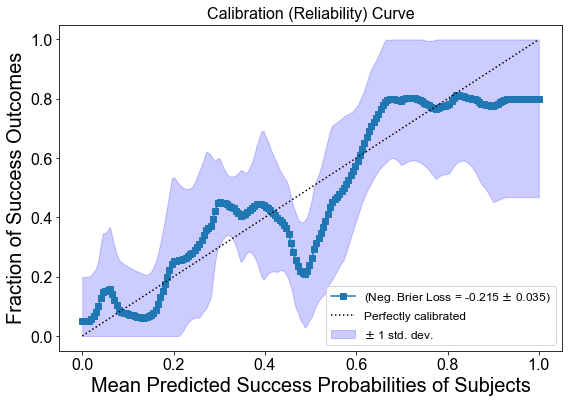

In [59]:
frac_pred_vals = []
mean_pred_values = np.linspace(0, 1.0, 200)

fig, ax = plt.subplots(figsize=(9, 6))
color = "blue"
for idx in range(n_splits):
    y_pred_proba = scores[f"{which_set}_y_pred_proba"][idx]

    mean_predicted_value = scores[f"{which_set}_mean_pred_value"][idx]
    fraction_of_positives = scores[f"{which_set}_fraction_pos"][idx]

    # create a linear interpolation of the calibration
    interp_frac_positives = np.interp(
        mean_pred_values, mean_predicted_value, fraction_of_positives
    )

    # store curves
    frac_pred_vals.append(interp_frac_positives)
#     ax.plot(mean_pred_values, interp_frac_positives, "s-", alpha=0.5)

# get the mean calibration curve
mean_frac_pred_values = np.mean(frac_pred_vals, axis=0)
ax.plot(
    mean_pred_values,
    mean_frac_pred_values,
    "s-",
    label=rf"(Neg. Brier Loss = {np.round(mean_brier,3)} $\pm$ {np.round(std_brier, 3)})",
)

# get upper and lower bound for tpr
std_fpv = np.std(frac_pred_vals, axis=0)
tprs_upper = np.minimum(mean_frac_pred_values + std_fpv, 1)
tprs_lower = np.maximum(mean_frac_pred_values - std_fpv, 0)
ax.fill_between(
    mean_pred_values,
    tprs_lower,
    tprs_upper,
    color=color,
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")


ax.set(
    ylabel="Fraction of Success Outcomes",
    ylim=[-0.05, 1.05],
    xlabel="Mean Predicted Success Probabilities of Subjects",
    title="Calibration (Reliability) Curve",
)

ax.legend(loc="lower right", fontsize=12)
plt.show()

fig.savefig(f"./{figure_dir}/hfo_calibration_curve.pdf", bbox_inches="tight")

# McNemars Test

In [60]:
from numpy.testing import assert_array_equal

In [61]:
from sklearn import preprocessing

enc = preprocessing.OrdinalEncoder()

In [62]:
y_target = []
y_modelhfo = []
y_modelss = []

y_subjs = []
for idx in range(n_splits):
    y = ss_scores["test_subjects"][idx]
    hfo_y = hfo_scores["test_subjects"][idx]

    assert_array_equal(y, hfo_y)
    y_subjs.extend(y)

    y_predhfo = hfo_scores["test_y_pred_proba"][idx]
    y_predss = ss_scores["test_y_pred_proba"][idx]
    y_modelhfo.extend(y_predhfo)
    y_modelss.extend(y_predss)

In [63]:
for subject in y_subjs:
    outcome = meta_df[meta_df["patient_id"] == subject]["outcome"].values[0]
    y_target.append(outcome)

y_target = enc.fit_transform(np.array(y_target)[:, np.newaxis]).squeeze()
y_modelss = np.array(y_modelss).round()
y_modelhfo = np.array(y_modelhfo).round()

In [64]:
tb = mcnemar_table(y_target=y_target, y_model1=y_modelss, y_model2=y_modelhfo)
print(tb)

[[114  44]
 [ 21  21]]


In [65]:
chi2, p = mcnemar(ary=tb, corrected=True)
print("chi-squared:", chi2)
print("p-value:", p)

chi-squared: 7.446153846153846
p-value: 0.006357215082587968


# Plots Comparing HFO and Source Sink

In [66]:
which_set = "test"

aucs = []
precisions = []
accuracys = []
sensitivitys = []
specificitys = []
clfs = []

for clf in ["HFO", "Source-Sink"]:
    if clf == "HFO":
        scores = hfo_scores
    elif clf == "Source-Sink":
        scores = ss_scores

    for idx in range(n_splits):
        auc_ = scores[f"{which_set}_roc_auc"][idx]
        precision_ = scores[f"{which_set}_average_precision"][idx]
        acc_ = scores[f"{which_set}_balanced_accuracy"][idx]
        sensitivity_ = scores[f"{which_set}_recall"][idx]
        specificity_ = scores[f"{which_set}_specificity"][idx]

        aucs.append(auc_)
        precisions.append(precision_)
        accuracys.append(acc_)
        sensitivitys.append(sensitivity_)
        specificitys.append(specificity_)
        clfs.append(clf)

comp_df = pd.DataFrame(
    (aucs, precisions, clfs, accuracys, specificitys, sensitivitys)
).T
comp_df.columns = [
    "AUC",
    "Precision",
    "Feature",
    "Accuracy",
    "Specificity",
    "Sensitivity",
]

In [67]:
comp_df_melt = pd.melt(
    comp_df,
    id_vars=["Feature"],
    value_vars=[
        "AUC",
        "Precision",
        "Accuracy",
        "Sensitivity",
        "Specificity",
    ],
    var_name="metric",
)

display(comp_df_melt.head())

,Feature,metric,value
0,HFO,AUC,0.828283
1,HFO,AUC,0.621212
2,HFO,AUC,0.656566
3,HFO,AUC,0.717172
4,HFO,AUC,0.636364


In [68]:
display(comp_df.head())

,AUC,Precision,Feature,Accuracy,Specificity,Sensitivity
0,0.828283,0.833267,HFO,0.752525,0.727273,0.777778
1,0.621212,0.596543,HFO,0.474747,0.727273,0.222222
2,0.656566,0.560953,HFO,0.651515,0.636364,0.666667
3,0.717172,0.705371,HFO,0.59596,0.636364,0.555556
4,0.636364,0.565305,HFO,0.606061,0.545455,0.666667


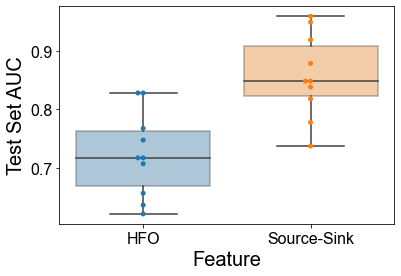

In [69]:
fig, ax = plt.subplots()
sns.boxplot(x="Feature", y="AUC", data=comp_df, ax=ax, boxprops=dict(alpha=0.4))
sns.swarmplot(x="Feature", y="AUC", data=comp_df, ax=ax)

ax.set(
    xlabel="Feature",
    ylabel="Test Set AUC",
)
plt.savefig(f"./{figure_dir}/compare_aucs_hilbert.pdf")

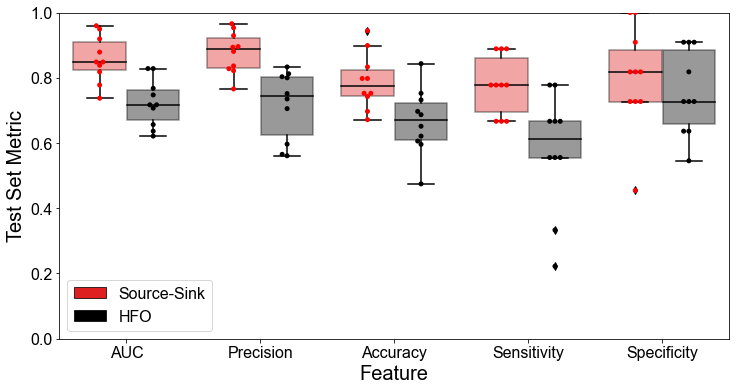

In [71]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    x="metric",
    y="value",
    hue="Feature",
    data=comp_df_melt,
    ax=ax,
    boxprops=dict(alpha=0.4),
    hue_order=["Source-Sink", "HFO"],
    palette=["red", "black"],
)
sns.swarmplot(
    x="metric",
    y="value",
    hue="Feature",
    data=comp_df_melt,
    ax=ax,
    dodge=True,
    hue_order=["Source-Sink", "HFO"],
    palette=["red", "black"],
)

ax.set(
    xlabel="Feature",
    ylabel="Test Set Metric",
    ylim=[0, 1],
)
h, l = ax.get_legend_handles_labels()
ax.legend(handles=[item for item in [h[0], h[1]]], labels=[item for item in l[-2:]])

# ax.legend(["HFO", "Source-Sink"])
fig.savefig(f"./{figure_dir}/compare_allmetrics_ss_hilbert.pdf", bbox_inches="tight")

## Predicted Probability of Success - Outcome, Engel, ILAE

In [72]:
display(hfo_proba_df.head())
display(ss_proba_df.head())

,y_proba,subject,outcome,engel,ilae,center,fold
0,0.332,PY19N023,S,1,1.0,JHH,0
1,0.1165,la16,F,4,5.0,CClinic,0
2,0.269,rns015,F,2,NaN,Miami,0
3,0.7615,upmc3,F,2,3.0,UPMC,0
4,0.6995,la21,S,1,1.0,CClinic,0


,y_proba,subject,outcome,engel,ilae,center,fold
0,0.609425,PY19N023,S,1,1.0,JHH,0
1,0.335533,la16,F,4,5.0,CClinic,0
2,0.292,rns015,F,2,NaN,Miami,0
3,0.653967,upmc3,F,2,3.0,UPMC,0
4,0.551758,la21,S,1,1.0,CClinic,0


In [73]:
hfo_proba_df["feature"] = "hfo"
ss_proba_df["feature"] = "ss"

all_proba_df = pd.concat((hfo_proba_df, ss_proba_df))
display(all_proba_df.head())

,y_proba,subject,outcome,engel,ilae,center,fold,feature
0,0.332,PY19N023,S,1,1.0,JHH,0,hfo
1,0.1165,la16,F,4,5.0,CClinic,0,hfo
2,0.269,rns015,F,2,NaN,Miami,0,hfo
3,0.7615,upmc3,F,2,3.0,UPMC,0,hfo
4,0.6995,la21,S,1,1.0,CClinic,0,hfo


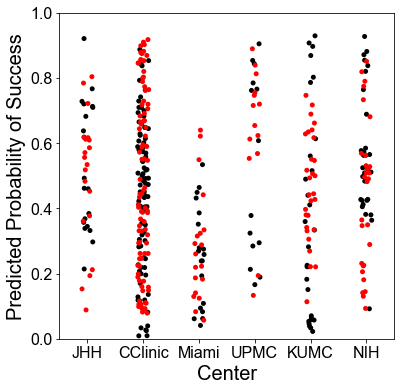

In [74]:
fig, ax = plt.subplots(figsize=(6, 6))
# sns.stripplot(x="outcome", y="y_proba", hue="center", data=proba_df, ax=ax)
sns.stripplot(
    x="center",
    y="y_proba",
    hue="feature",
    data=all_proba_df,
    ax=ax,
    # boxprops=dict(alpha=0.4),
    hue_order=["ss", "hfo"],
    palette=["red", "black"],
)
# sns.boxplot(
#     x="outcome",
#     y="y_proba",
#     hue='feature',
#     data=proba_df,
#     ax=ax,
#     boxprops=dict(alpha=0.4),
#     hue_order=["Source-Sink", "HFO"],
#     palette=["red", "black"],
#     # palette=["black", "red"],
# )
# sns.swarmplot(x="outcome", y="y_proba", hue="center", data=proba_df, ax=ax,
#                  hue_order=["Source-Sink", "HFO"],
#     palette=["red", "black"],)

ax.set(ylabel="Predicted Probability of Success", xlabel="Center", ylim=[0, 1])
_lg = ax.get_legend()
_lg.remove()
# fig.savefig(
#     f"./{figure_dir}/ss_and_hilberthfo_y_pred_proba_center.pdf",
#     bbox_inches="tight",
# )

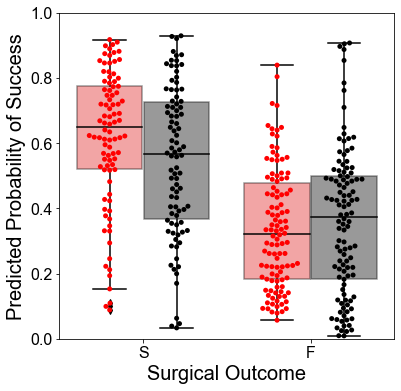

In [75]:
fig, ax = plt.subplots(figsize=(6, 6))
# sns.stripplot(x="outcome", y="y_proba", hue="center", data=proba_df, ax=ax)
sns.swarmplot(
    x="outcome",
    y="y_proba",
    hue="feature",
    data=all_proba_df,
    ax=ax,
    # boxprops=dict(alpha=0.4),
    hue_order=["ss", "hfo"],
    palette=["red", "black"],
    dodge=True,
)
sns.boxplot(
    x="outcome",
    y="y_proba",
    hue="feature",
    data=all_proba_df,
    ax=ax,
    boxprops=dict(alpha=0.4),
    hue_order=["ss", "hfo"],
    palette=["red", "black"],
)

ax.set(
    ylabel="Predicted Probability of Success", xlabel="Surgical Outcome", ylim=[0, 1]
)
_lg = ax.get_legend()
_lg.remove()
fig.savefig(
    f"./{figure_dir}/ss_and_hilberthfo_y_pred_proba_surgical_outcomes.pdf",
    bbox_inches="tight",
)

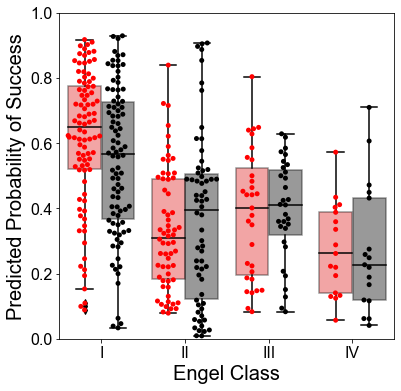

In [76]:
fig, ax = plt.subplots(figsize=(6, 6))
# sns.stripplot(x="outcome", y="y_proba", hue="center", data=proba_df, ax=ax)
sns.swarmplot(
    x="engel",
    y="y_proba",
    hue="feature",
    data=all_proba_df,
    ax=ax,
    # boxprops=dict(alpha=0.4),
    hue_order=["ss", "hfo"],
    palette=["red", "black"],
    dodge=True,
    order=[1, 2, 3, 4],
)
sns.boxplot(
    x="engel",
    y="y_proba",
    hue="feature",
    data=all_proba_df,
    ax=ax,
    boxprops=dict(alpha=0.4),
    hue_order=["ss", "hfo"],
    palette=["red", "black"],
    order=[1, 2, 3, 4],
)

ax.set(ylabel="Predicted Probability of Success", xlabel="Engel Class", ylim=[0, 1])
ax.set_xticklabels(["I", "II", "III", "IV"])

_lg = ax.get_legend()
_lg.remove()

fig.savefig(
    f"./{figure_dir}/ss_and_hilberthfo_y_pred_proba_engel.pdf", bbox_inches="tight"
)

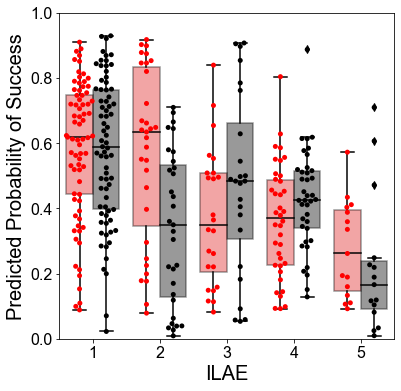

In [77]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.swarmplot(
    x="ilae",
    y="y_proba",
    hue="feature",
    data=all_proba_df,
    ax=ax,
    # boxprops=dict(alpha=0.4),
    hue_order=["ss", "hfo"],
    palette=["red", "black"],
    dodge=True,
    order=[1, 2, 3, 4, 5],
)
sns.boxplot(
    x="ilae",
    y="y_proba",
    hue="feature",
    data=all_proba_df,
    ax=ax,
    boxprops=dict(alpha=0.4),
    hue_order=["ss", "hfo"],
    palette=["red", "black"],
    order=[1, 2, 3, 4, 5],
)

ax.set(ylabel="Predicted Probability of Success", xlabel="ILAE", ylim=[0, 1])

_lg = ax.get_legend()
_lg.remove()

fig.savefig(
    f"./{figure_dir}/ss_and_hilberthfo_y_pred_proba_ilae.pdf", bbox_inches="tight"
)